In [65]:
from torchdyn.core import NeuralODE
from torchdyn.models import CNF, hutch_trace, autograd_trace
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.datasets import *
from torchdyn.utils import *

In [66]:
# quick run for automated notebook validation
dry_run = False

In [81]:
1 << 14

16384

16384


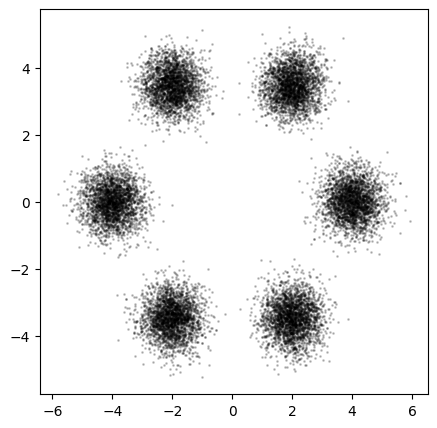

In [78]:
data = ToyDataset()
n_samples = 1 << 14
n_gaussians = 6 
X, yn = data.generate(n_samples // n_gaussians, 'gaussians', n_gaussians=6, std_gaussians=0.5, radius=4, dim=2)
#X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c='black', alpha=0.2, s=1.)
print(n_samples)
plt.show()

In [68]:
print(X.shape)
print(yn.shape)
print(X[:10])
print(yn[:10])


torch.Size([16380, 2])
torch.Size([16380])
tensor([[0.5793, 1.4498],
        [0.5494, 0.9344],
        [0.9058, 1.4545],
        [0.6862, 1.4670],
        [0.9027, 1.2133],
        [0.9182, 1.2124],
        [0.4364, 1.0950],
        [0.6344, 1.1939],
        [0.9157, 0.9377],
        [0.7863, 1.1864]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [69]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn).long().to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=1024, shuffle=True) 

In [70]:
device

device(type='cuda', index=0)

In [71]:
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2),
    )
# cnf wraps the net as with other energy models
# default trace_estimator, when not specified, is autograd_trace


In [72]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical


In [73]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, net:nn.Module):
        super().__init__()
        self.net = net
        self.iters = 0
        self.cnf = CNF(self.net, trace_estimator=autograd_trace)
        self.nde = NeuralODE(self.cnf, solver='dopri5', sensitivity='adjoint', atol=1e-4, rtol=1e-4)
        self.model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),self.nde)
        self.prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
        
    def forward(self, x):
        return self.model(x)
    
    def sample(self, num_samples):
        sample = self.prior.sample(torch.Size([num_samples]))
        # integrating from 1 to 0
        self.model[1].t_span = torch.linspace(1, 0, 2)
        new_x = self.model(sample)[1]
        return new_x
        
    def training_step(self, batch, batch_idx):
        self.iters += 1
        x, _ = batch 
        t, xtrJ = self.model(x)
        logprob = self.prior.log_prob(xtrJ[1, :,1:]) - xtrJ[1, :,0] # logp(z_S) = logp(z_0) - \int_0^S trJ
        loss = -torch.mean(logprob)
        self.nde.nfe = 0
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=2e-3, weight_decay=1e-5)

    def train_dataloader(self):
        return trainloader

In [74]:
learn = Learner(f)
trainer = pl.Trainer(max_epochs=32)
trainer.fit(learn)

/beegfs/desy/user/ewencedr/conda/envs/pllhydra/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ewencedr/.local/lib/python3.9/site-packages/ip ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/beegfs/desy/user/ewencedr/conda/envs/pllhydra/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type       | Params
-------------------------------------
0 | net   | Sequential | 8.6 K 
1 | cnf   | CNF        | 8.6 K 
2 | nde   | NeuralODE  | 8.6 K 
3 | model | Seque

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/beegfs/desy/user/ewencedr/conda/envs/pllhydra/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/beegfs/desy/user/ewencedr/conda/envs/pllhydra/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/beegfs/desy/user/ewencedr/conda/envs/pllhydra/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [60]:
new_x = learn.sample(10).cpu().detach()[1]
#new_x = learn.sample(10)

Text(0.5, 1.0, 'Data')

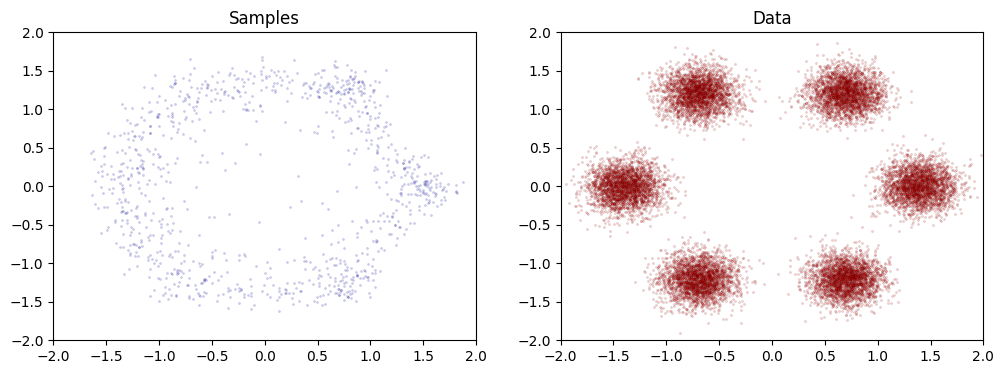

In [61]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=2.3, alpha=0.2, linewidths=0.3, c='blue', edgecolors='black')
plt.xlim(-2, 2) ; plt.ylim(-2, 2)
plt.title('Samples')

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=2.3, alpha=0.2, c='red',  linewidths=0.3, edgecolors='black')
plt.xlim(-2, 2) ; plt.ylim(-2, 2)
plt.title('Data')

In [ ]:
traj = model[1].trajectory(Augmenter(1, 1)(sample.to(device)), t_span=torch.linspace(1, 0, 100)).detach().cpu()
sample = sample.cpu()
traj = traj[:, :, 1:] # scrapping first dimension := jacobian trace

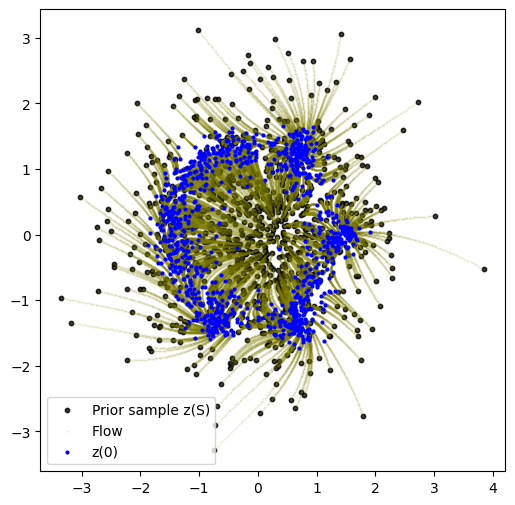

In [ ]:
n = 2000
plt.figure(figsize=(6,6))
plt.scatter(sample[:n,0], sample[:n,1], s=10, alpha=0.8, c='black')
plt.scatter(traj[:,:n,0], traj[:,:n,1], s=0.2, alpha=0.2, c='olive')
plt.scatter(traj[-1,:n,0], traj[-1,:n,1], s=4, alpha=1, c='blue')
plt.legend(['Prior sample z(S)', 'Flow', 'z(0)'])